In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import gym
import gym_safety
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from stable_baselines import DQN
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.evaluation import evaluate_policy
from stable_baselines.common.vec_env import VecVideoRecorder, DummyVecEnv
from stable_baselines import results_plotter
from stable_baselines.bench import Monitor

In [2]:
# Create log dir
log_dir = "tmp/"
os.makedirs(log_dir, exist_ok=True)

In [3]:
env = gym.make('CartSafe-v0')
env = Monitor(env, log_dir)

/usr/local/Caskroom/miniconda/base/envs/safety-basic/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [8]:
dqn_model = DQN('MlpPolicy', env, 
                learning_rate=3e-3, 
                prioritized_replay=True, 
                batch_size=256,
                tensorboard_log="logs",
                verbose=1)

In [9]:
# Train the agent
dqn_model.learn(total_timesteps=int(5e4), log_interval=10, tb_log_name='dqn')
# Save the agent
dqn_model.save("dqn_constraint")

--------------------------------------
| % time spent exploring  | 74       |
| episodes                | 10       |
| mean 100 episode reward | 17.4     |
| steps                   | 1276     |
--------------------------------------
--------------------------------------
| % time spent exploring  | 53       |
| episodes                | 20       |
| mean 100 episode reward | 11.4     |
| steps                   | 2348     |
--------------------------------------
--------------------------------------
| % time spent exploring  | 33       |
| episodes                | 30       |
| mean 100 episode reward | 10.6     |
| steps                   | 3395     |
--------------------------------------
--------------------------------------
| % time spent exploring  | 22       |
| episodes                | 40       |
| mean 100 episode reward | 10.5     |
| steps                   | 3971     |
--------------------------------------
--------------------------------------
| % time spent exploring 

In [ ]:
#model.load('dqn_constraint')

In [10]:
mean_reward, std_reward = evaluate_policy(dqn_model, env, n_eval_episodes=100)
print(mean_reward, std_reward)

226.60135096446047 56.69821953989566


In [ ]:
results_plotter.plot_results([log_dir], 2e4, results_plotter.X_TIMESTEPS, "DQN")
plt.show()

/usr/local/Caskroom/miniconda/base/envs/safety-basic/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


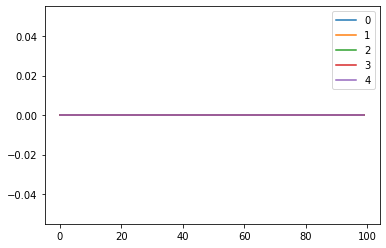

In [12]:
env = DummyVecEnv([lambda: gym.make('CartSafe-v0')])
history = []

# Record the video starting at the first step
#video_folder = 'logs/videos/'
#video_length = 100
#env = VecVideoRecorder(env, video_folder,
#                       record_video_trigger=lambda x: x == 0, video_length=video_length,
#                       name_prefix="dqn-agent")

for _ in range(5): #episodes
    episode = []
    _ = env.reset()
    for _ in range(100): #timesteps
        obs = env.reset()
        action, _ = dqn_model.predict(obs)
        obs, reward, done, info = env.step(action)
        episode.append([obs, reward, done, info])
        env.render()
        #print(f"{obs}\n {reward}\n {done}\n {info}\n")
    history.append(episode)
    env.close()


def get_constraint_cost(episode):
    return list(episode[k][3][0].get('constraint_costs')[0] for k in range(len(episode)))

def evaluate_safety(history):
    constraint_cost = [get_constraint_cost(history[k]) for k in range(len(history))]
    for i, cost in enumerate(constraint_cost):
        plt.plot(cost, label=str(i))
        
    plt.legend()
    plt.show()
    
evaluate_safety(history)